✅ Standardized SA_Score & SBDS_score → SA_z, SBSOD_z
                    Robust linear Model Regression Results                    
Dep. Variable:             tap_rate_z   No. Observations:                 2399
Model:                            RLM   Df Residuals:                     2392
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Nov 2025                                         
Time:                        10:03:36                                         
No. Iterations:                    19                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

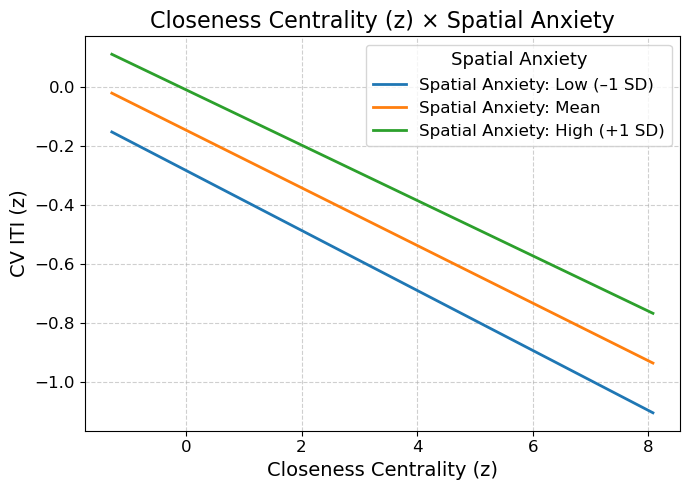

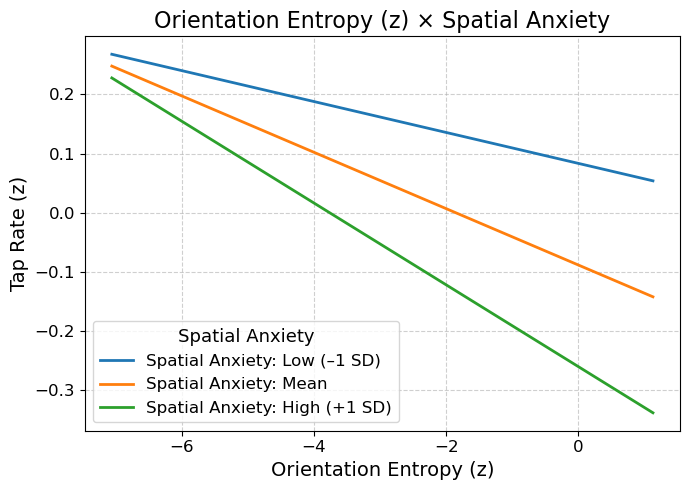

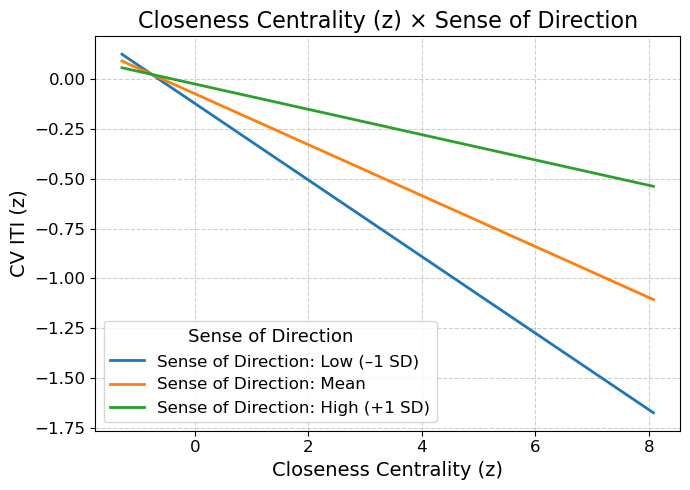

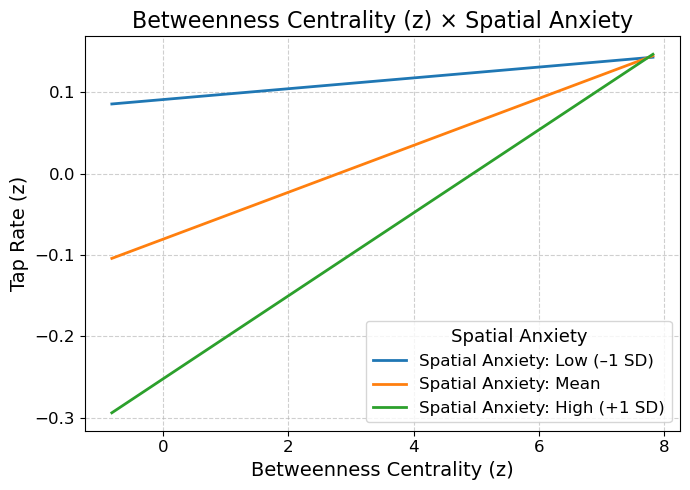

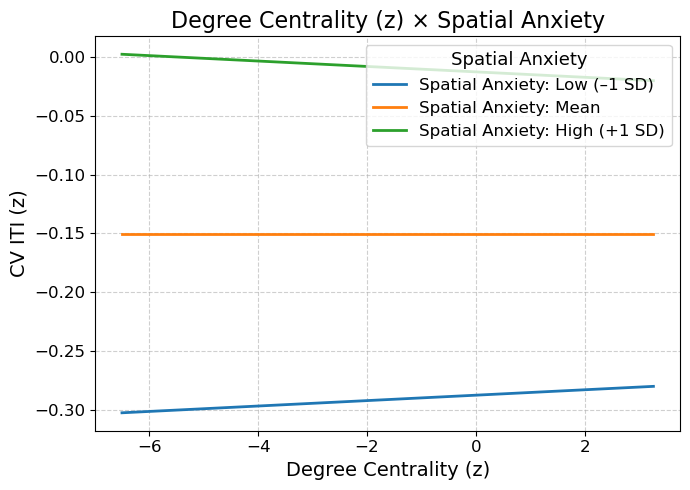

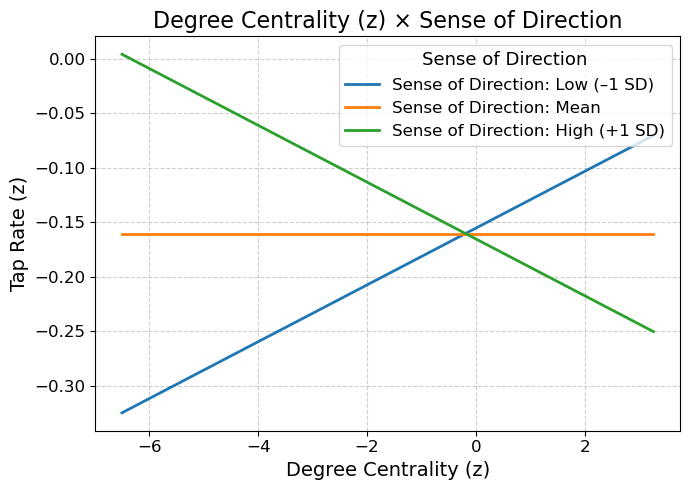

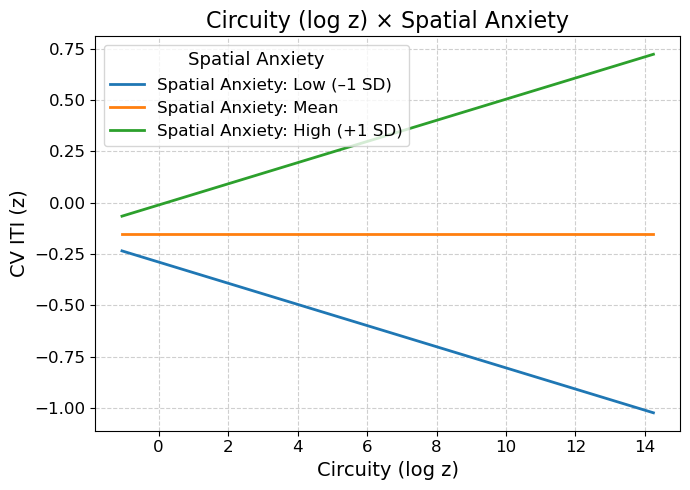

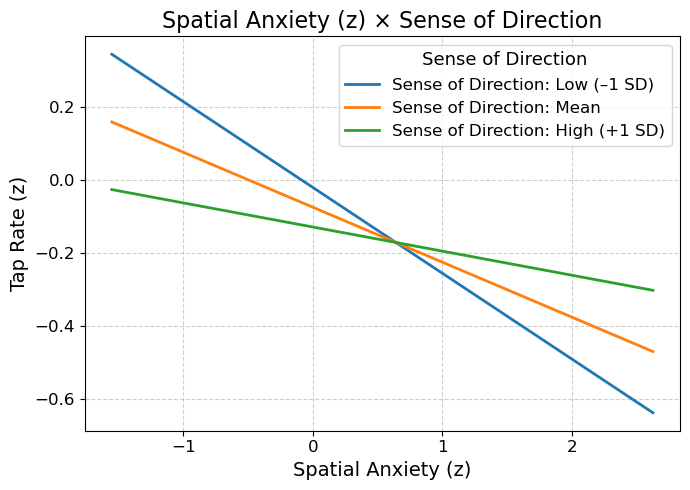

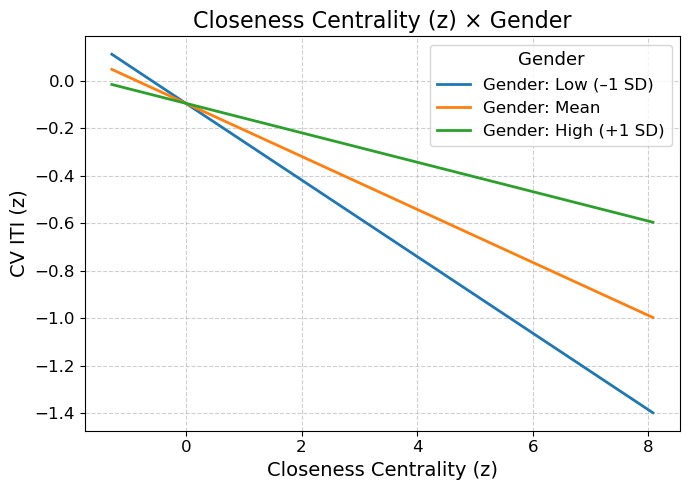

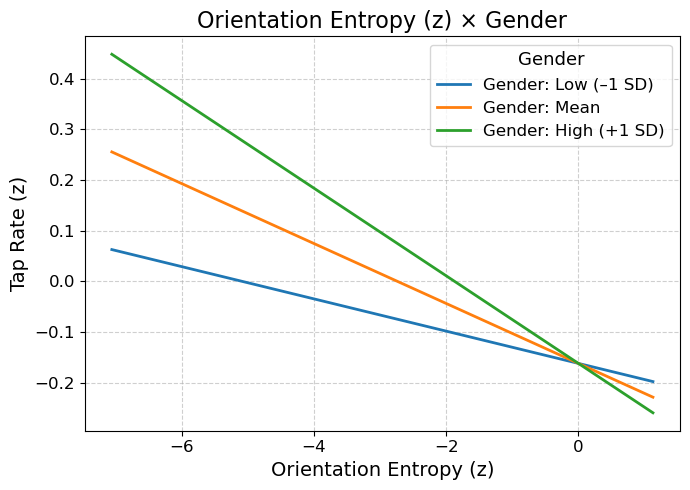

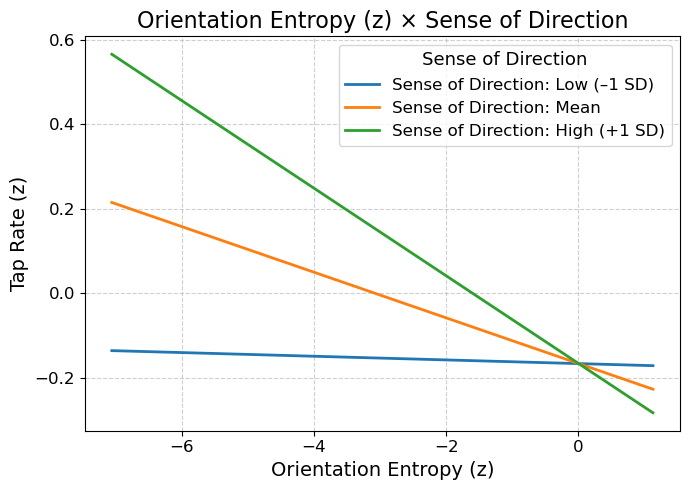

In [4]:

import pandas as pd
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import os

os.makedirs("./figures/moderation", exist_ok=True)


# === CONFIG ===
DATA_PATH = '../data/pre-processed_anonimized_final_clean.csv'

# === STEP 0: Load dataset ===
df = pd.read_csv(DATA_PATH)

# Create Gender_M if needed
if "Gender_M" not in df.columns and "Gender" in df.columns:
    df["Gender_M"] = (df["Gender"].astype(str).str.upper().str[0] == "M").astype(float)

# Standardize SA_Score and SBDS_score into SA_z and SBSOD_z if needed
if "SA_z" not in df.columns or "SBSOD_z" not in df.columns:
    needed = {"SA_Score", "SBDS_score"} 
    if needed.issubset(df.columns):
        scaler = StandardScaler()
        df[["SA_z", "SBSOD_z"]] = scaler.fit_transform(df[["SA_Score", "SBDS_score"]])
        print("✅ Standardized SA_Score & SBDS_score → SA_z, SBSOD_z")
    else:
        raise ValueError("Required columns for standardization not found: SA_Score, SBDS_score")

# === STEP 1: Create interaction terms ===
df['entropy_SBSOD'] = df['orientation_entropy_z'] * df['SBSOD_z']
df['betweenness_SA'] = df['betweenness_log_z'] * df['SA_z']
df['degree_SA'] = df['degree_mean_z'] * df['SA_z']
df['degree_SBSOD'] = df['degree_mean_z'] * df['SBSOD_z']
df['circuity_SA'] = df['circuity_log_z'] * df['SA_z']
df['SA_SBSOD'] = df['SA_z'] * df['SBSOD_z']
df['closeness_SA'] = df['closeness_log_z'] * df['SA_z']
df['closeness_SBSOD'] = df['closeness_log_z'] * df['SBSOD_z']
df['closeness_Gender'] = df['closeness_log_z'] * df['Gender_M']
df['entropy_Gender'] = df['orientation_entropy_z'] * df['Gender_M']
df['entropy_SA'] = df['orientation_entropy_z'] * df['SA_z']

# === STEP 2: Define models ===
models_info = [
    (['orientation_entropy_z', 'SBSOD_z', 'entropy_SBSOD', 'degree_mean_z', 'circuity_log_z', 'Gender_M'], 'tap_rate_z', 'entropy_SBSOD', 'Model 4: Entropy × SBSOD'),
    (['betweenness_log_z', 'SA_z', 'betweenness_SA', 'degree_mean_z', 'circuity_log_z', 'Gender_M'], 'tap_rate_z', 'betweenness_SA', 'Model 5: Betweenness × SA'),
    (['degree_mean_z', 'SA_z', 'degree_SA', 'circuity_log_z', 'Gender_M'], 'cv_iti_z', 'degree_SA', 'Model 6: Degree × SA'),
    (['degree_mean_z', 'SBSOD_z', 'degree_SBSOD', 'circuity_log_z', 'Gender_M'], 'tap_rate_z', 'degree_SBSOD', 'Model 7: Degree × SBSOD'),
    (['circuity_log_z', 'SA_z', 'circuity_SA', 'degree_mean_z', 'Gender_M'], 'cv_iti_z', 'circuity_SA', 'Model 8: Circuity × SA'),
    (['SA_z', 'SBSOD_z', 'SA_SBSOD', 'degree_mean_z', 'circuity_log_z', 'Gender_M'], 'tap_rate_z', 'SA_SBSOD', 'Model 9: SA × SBSOD'),
    (['closeness_log_z', 'SA_z', 'closeness_SA', 'degree_mean_z', 'circuity_log_z', 'Gender_M'], 'cv_iti_z', 'closeness_SA', 'Model 1: Closeness × SA'),
    (['orientation_entropy_z', 'SA_z', 'entropy_SA', 'degree_mean_z', 'circuity_log_z', 'Gender_M'], 'tap_rate_z', 'entropy_SA', 'Model 2: Entropy × SA'),
    (['closeness_log_z', 'SBSOD_z', 'closeness_SBSOD', 'degree_mean_z', 'circuity_log_z', 'Gender_M'], 'cv_iti_z', 'closeness_SBSOD', 'Model 3: Closeness × SBSOD'),
    (['closeness_log_z', 'Gender_M', 'closeness_Gender', 'degree_mean_z', 'circuity_log_z'], 'cv_iti_z', 'closeness_Gender', 'Model 10: Closeness × Gender'),
    (['orientation_entropy_z', 'Gender_M', 'entropy_Gender', 'degree_mean_z', 'circuity_log_z'], 'tap_rate_z', 'entropy_Gender', 'Model 11: Entropy × Gender'),
]

# === STEP 3: Fit models ===
interaction_results = []
fitted_models = {}

for X_vars, y_var, interaction_term, label in models_info:
    X = df[X_vars].copy()
    X = sm.add_constant(X)
    y = df[y_var]
    mask = X.notna().all(axis=1) & y.notna()
    model = sm.RLM(y[mask], X[mask], M=HuberT()).fit()
    print(model.summary())
    interaction_results.append({
        'Model': label,
        'Interaction Term': interaction_term,
        'Coefficient': model.params.get(interaction_term, float('nan')),
        'p-value': model.pvalues.get(interaction_term, float('nan')),
        'SE': model.bse.get(interaction_term, float('nan'))
    })
    fitted_models[label] = model

interaction_df = pd.DataFrame(interaction_results)
print("\n=== Interaction Term Comparison ===")
print(interaction_df[['Model', 'Interaction Term', 'Coefficient', 'p-value','SE']].round(4))

# === STEP 4: Plotting function ===
def plot_interaction_high_quality(df, x_var, moderator_var, interaction_var, model, x_label, y_label, moderator_name):
    x_range = np.linspace(df[x_var].min(), df[x_var].max(), 100)
    mod_mean = df[moderator_var].mean()
    mod_sd = df[moderator_var].std()

    plt.figure(figsize=(7, 5))
    for level, label in [(-1, f"{moderator_name}: Low (–1 SD)"),
                         (0, f"{moderator_name}: Mean"),
                         (1, f"{moderator_name}: High (+1 SD)")]:
        mod_value = mod_mean + level * mod_sd
        interaction_value = x_range * mod_value
        df_pred = pd.DataFrame({
            'const': 1.0,
            x_var: x_range,
            moderator_var: mod_value,
            interaction_var: interaction_value,
            'degree_mean_z': 0,
            'circuity_log_z': 0,
            'Gender_M': 0
        })
        preds = model.predict(df_pred)
        plt.plot(x_range, preds, label=label, linewidth=2)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.title(f'{x_label} × {moderator_name}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title=moderator_name, fontsize=12, title_fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"./figures/moderation/{interaction_var}.png", dpi=600)
    plt.show()


# === STEP 5: Generate moderation plots ===

plot_interaction_high_quality(df, 'closeness_log_z', 'SA_z', 'closeness_SA',
                 fitted_models['Model 1: Closeness × SA'],
                 x_label='Closeness Centrality (z)', y_label='CV ITI (z)', moderator_name='Spatial Anxiety')

plot_interaction_high_quality(df, 'orientation_entropy_z', 'SA_z', 'entropy_SA',
                 fitted_models['Model 2: Entropy × SA'],
                 x_label='Orientation Entropy (z)', y_label='Tap Rate (z)', moderator_name='Spatial Anxiety')

plot_interaction_high_quality(df, 'closeness_log_z', 'SBSOD_z', 'closeness_SBSOD',
                 fitted_models['Model 3: Closeness × SBSOD'],
                 x_label='Closeness Centrality (z)', y_label='CV ITI (z)', moderator_name='Sense of Direction')

plot_interaction_high_quality(df, 'betweenness_log_z', 'SA_z', 'betweenness_SA',
                 fitted_models['Model 5: Betweenness × SA'],
                 x_label='Betweenness Centrality (z)', y_label='Tap Rate (z)', moderator_name='Spatial Anxiety')

plot_interaction_high_quality(df, 'degree_mean_z', 'SA_z', 'degree_SA',
                 fitted_models['Model 6: Degree × SA'],
                 x_label='Degree Centrality (z)', y_label='CV ITI (z)', moderator_name='Spatial Anxiety')

plot_interaction_high_quality(df, 'degree_mean_z', 'SBSOD_z', 'degree_SBSOD',
                 fitted_models['Model 7: Degree × SBSOD'],
                 x_label='Degree Centrality (z)', y_label='Tap Rate (z)', moderator_name='Sense of Direction')

plot_interaction_high_quality(df, 'circuity_log_z', 'SA_z', 'circuity_SA',
                 fitted_models['Model 8: Circuity × SA'],
                 x_label='Circuity (log z)', y_label='CV ITI (z)', moderator_name='Spatial Anxiety')

plot_interaction_high_quality(df, 'SA_z', 'SBSOD_z', 'SA_SBSOD',
                 fitted_models['Model 9: SA × SBSOD'],
                 x_label='Spatial Anxiety (z)', y_label='Tap Rate (z)', moderator_name='Sense of Direction')

plot_interaction_high_quality(df, 'closeness_log_z', 'Gender_M', 'closeness_Gender',
                 fitted_models['Model 10: Closeness × Gender'],
                 x_label='Closeness Centrality (z)', y_label='CV ITI (z)', moderator_name='Gender')

plot_interaction_high_quality(df, 'orientation_entropy_z', 'Gender_M', 'entropy_Gender',
                 fitted_models['Model 11: Entropy × Gender'],
                 x_label='Orientation Entropy (z)', y_label='Tap Rate (z)', moderator_name='Gender')

plot_interaction_high_quality(df, 'orientation_entropy_z', 'SBSOD_z', 'entropy_SBSOD',
                 fitted_models['Model 4: Entropy × SBSOD'],
                 x_label='Orientation Entropy (z)', y_label='Tap Rate (z)', moderator_name='Sense of Direction')
